# Preprocess images
In this notebook we will preprocess geoTIFFs and manually labeled data geoJSON files into training data for deep learning

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import geopandas as gpd
import rasterio
import solaris as sol

c:\Users\HarrisonK\AppData\Local\miniforge3\envs\geo\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\HarrisonK\AppData\Local\miniforge3\envs\geo\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\HarrisonK\AppData\Local\miniforge3\envs\geo\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\HarrisonK\App

In [2]:
# First create a data directory and subdirectories for images and masks
data_dir = Path('./data')
data_dir.mkdir(exist_ok=True)

image_path = data_dir / 'images-256'
image_path.mkdir(exist_ok=True)

mask_path = data_dir / 'masks-256'
mask_path.mkdir(exist_ok=True)

We'll get data from the Tanzania Open AI Challenge dataset of 7-cm resolution drone imagery and manually labeled building footprints. We'll create training and validation datasets from a single drone image (cloud-optimised geoTIFF) and its corresponding geoJSON file of building footprints.

,pk_0,pk,pkuid,building,unfinished,problemati,changeset,area,condition,geometry
0,1,None,None,None,None,None,None,None,Complete,"POLYGON ((39.30436 -5.72267, 39.30438 -5.72264..."
1,2,None,None,None,None,None,None,None,Complete,"POLYGON ((39.29424 -5.72488, 39.29428 -5.72481..."
2,3,None,None,None,None,None,None,None,Complete,"POLYGON ((39.29415 -5.72492, 39.29423 -5.72488..."
3,4,None,None,None,None,None,None,None,Complete,"POLYGON ((39.29405 -5.72494, 39.29414 -5.72493..."
4,5,None,None,None,None,None,None,None,Complete,"POLYGON ((39.29397 -5.72490, 39.29405 -5.72494..."


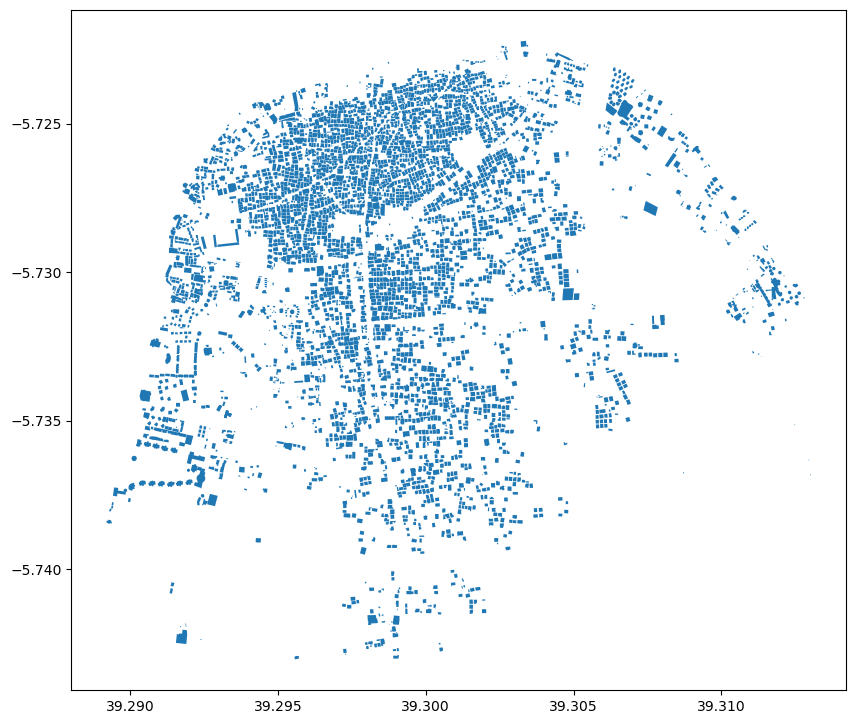

In [3]:
# Load the geojson file with the building footprints into a GeoDataFrame and remove null geometries
labels_gdf = gpd.read_file('./data/raw-inputs/znz001_labels.geojson')
labels_gdf = labels_gdf[labels_gdf['geometry'].notnull()]

# Visualize the GeoDataFrame
labels_gdf.plot(figsize=(10, 10))
labels_gdf.head()

## We'll use geojson.io to draw train and validation areas
As we are using a single image, we'll draw polygons for training and validation data. Using geojson.io we will draw `train` and `validation` polygons in geoJSON format and add `dataset: train` and `dataset: validation` properties to each polygon. We'll save the geoJSON file as `train.geojson` and `validation.geojson` respectively.

Here is the [GeoJSON file](https://geojson.io/#id=gist:daveluo/8e192744b2aa377db162bc34e0e0ae64&map=13.3/-5.73423/39.29834) file that I created in geojson.io.

## Generate slippy map tile polygons using supermercado and geopandas

Next we'll use [`supermercado`](https://github.com/mapbox/supermercado) to generate square polygons representing each slippy map tile that we'll create from the tiff image. We'll specify a zoom level and make use of the geoJSON `training` and `validation` polygons to assign the resulting tiles to either the training or validation dataset.

We'll be using slippy map tiles of `tile_size = 256` and `zoom = 19` which is a good balance between image resolution and processing time for the number of tiles.

Then we will merge the supermercado tile polygons into one GeoDataFrame using `geopandas`.

<AxesSubplot:>

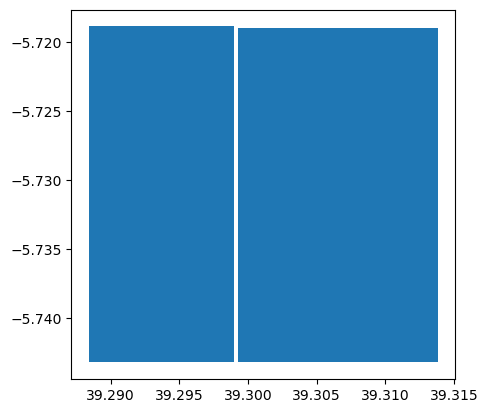

In [4]:
# Import the geojson.io train/test polygons file
train_val_areas_gdf = gpd.read_file('./data/raw-inputs/train_test_polygons.geojson')

TILE_SIZE = 256
ZOOM_LEVEL = 19

# Plot the train/test polygons
train_val_areas_gdf.plot()

In [5]:
# Create two geoJSON files for the train and test polygons
train_areas_gdf = train_val_areas_gdf[train_val_areas_gdf['dataset'] == 'train']
train_areas_gdf.to_file('./data/polygons/train_area.geojson', driver='GeoJSON')

test_areas_gdf = train_val_areas_gdf[train_val_areas_gdf['dataset'] == 'validation']
test_areas_gdf.to_file('./data/polygons/validation_area.geojson', driver='GeoJSON')

Use `supermercado burn` to take the input geoJSON train and validation polygon files and return a stream of slippy map tile polygons at the specified zoom level. The usage is `<{geojson} stream> | supermercado burn <zoom> | fio collect > {output_filename.geojson}`. Run the following commands from a bash terminal to generate the slippy map tile polygons for the training and validation datasets

In [11]:
command_train = f"cat data/polygons/train_area.geojson | supermercado burn {ZOOM_LEVEL} | mercantile shapes | fio collect > data/polygons/train_z{ZOOM_LEVEL}tiles.geojson"

command_validation = f"cat data/polygons/validation_area.geojson | supermercado burn {ZOOM_LEVEL} | mercantile shapes | fio collect > data/polygons/validation_z{ZOOM_LEVEL}tiles.geojson"

print(command_train, '\n')
print(command_validation)

cat data/polygons/train_area.geojson | supermercado burn 19 | mercantile shapes | fio collect > data/polygons/train_z19tiles.geojson 

cat data/polygons/validation_area.geojson | supermercado burn 19 | mercantile shapes | fio collect > data/polygons/validation_z19tiles.geojson


In [16]:
# Read back in the train and validation tiles generated from the command line
train_tiles = gpd.read_file('./data/polygons/train_z19tiles.geojson')
validation_tiles = gpd.read_file('./data/polygons/validation_z19tiles.geojson')

# Add the train and validation labels to a new column called 'dataset'
train_tiles['dataset'] = 'train'
validation_tiles['dataset'] = 'validation'

train_tiles.head()

,id,title,geometry,dataset
0,"(319377, 270486, 19)","XYZ tile (319377, 270486, 19)","POLYGON ((39.29878 -5.71916, 39.29878 -5.71848...",train
1,"(319378, 270486, 19)","XYZ tile (319378, 270486, 19)","POLYGON ((39.29947 -5.71916, 39.29947 -5.71848...",train
2,"(319379, 270486, 19)","XYZ tile (319379, 270486, 19)","POLYGON ((39.30016 -5.71916, 39.30016 -5.71848...",train
3,"(319380, 270486, 19)","XYZ tile (319380, 270486, 19)","POLYGON ((39.30084 -5.71916, 39.30084 -5.71848...",train
4,"(319381, 270486, 19)","XYZ tile (319381, 270486, 19)","POLYGON ((39.30153 -5.71916, 39.30153 -5.71848...",train


<AxesSubplot:>

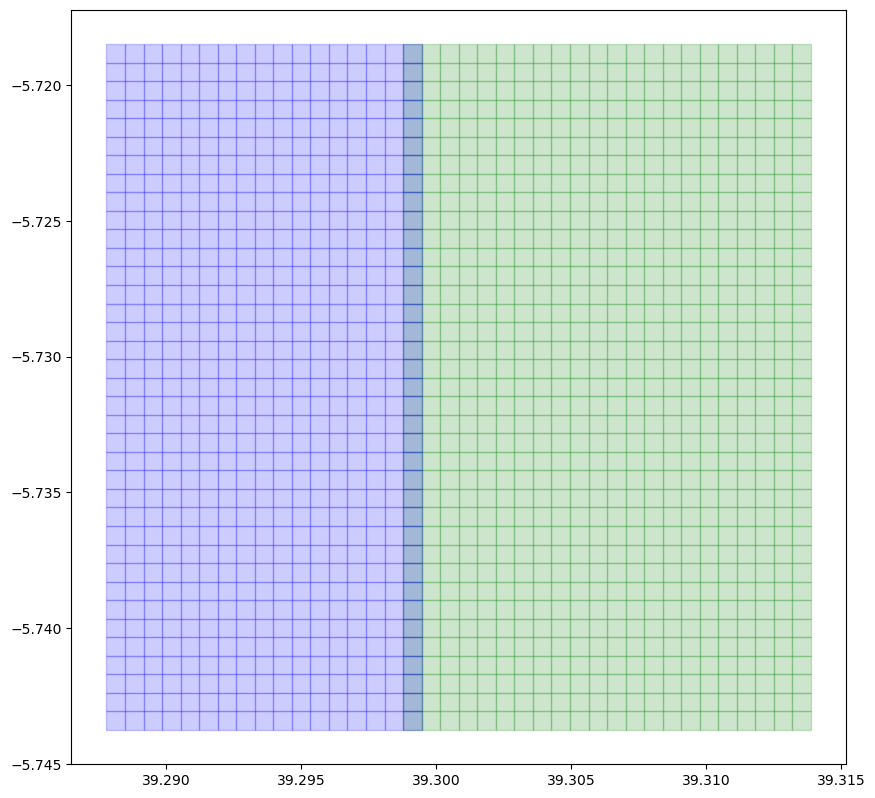

In [20]:
# Check overlapping tiles between training and validation
fig, ax = plt.subplots(figsize=(10, 10))
train_tiles.plot(ax=ax, color='green', alpha=0.2, edgecolor='green')
validation_tiles.plot(ax=ax, color='blue', alpha=0.2, edgecolor='blue')

id            object
title         object
geometry    geometry
dataset       object
dtype: object


,id,title,geometry,dataset
0,"(319377, 270486, 19)","XYZ tile (319377, 270486, 19)","POLYGON ((39.29878 -5.71916, 39.29878 -5.71848...",train
1,"(319378, 270486, 19)","XYZ tile (319378, 270486, 19)","POLYGON ((39.29947 -5.71916, 39.29947 -5.71848...",train
2,"(319379, 270486, 19)","XYZ tile (319379, 270486, 19)","POLYGON ((39.30016 -5.71916, 39.30016 -5.71848...",train
3,"(319380, 270486, 19)","XYZ tile (319380, 270486, 19)","POLYGON ((39.30084 -5.71916, 39.30084 -5.71848...",train
4,"(319381, 270486, 19)","XYZ tile (319381, 270486, 19)","POLYGON ((39.30153 -5.71916, 39.30153 -5.71848...",train


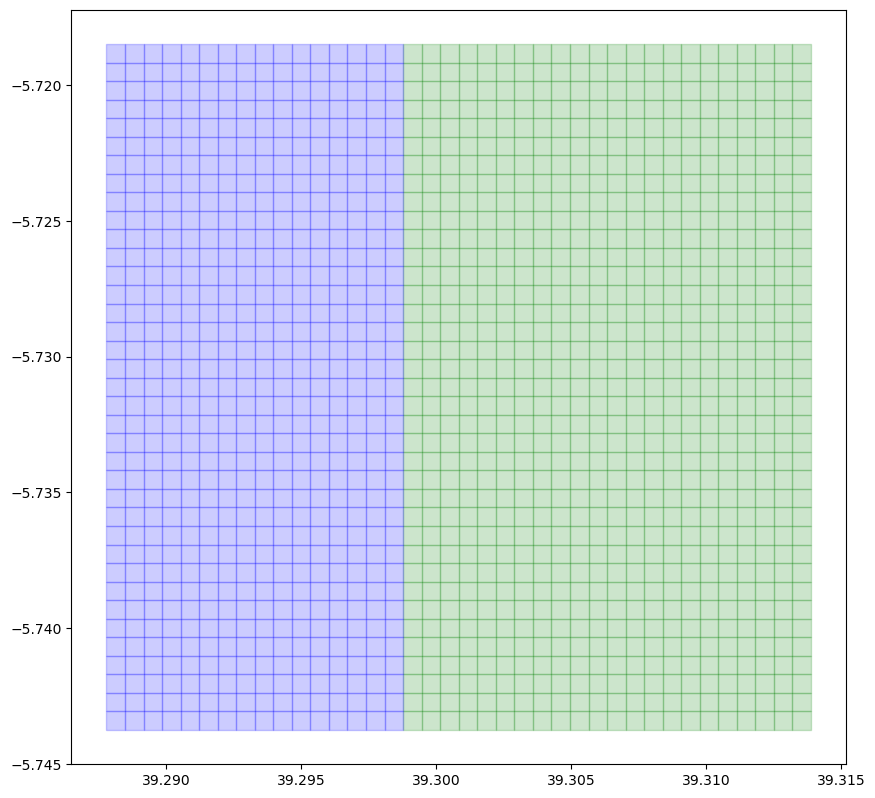

In [35]:
# Merge the train and validation tiles into a single GeoDataFrame dropping any duplicates
tiles_gdf = gpd.GeoDataFrame(pd.concat([train_tiles, validation_tiles], ignore_index=True), crs=train_tiles.crs)
tiles_gdf.drop_duplicates(subset=['id'], inplace=True)

# Plot the merged tiles
fig, ax = plt.subplots(figsize=(10, 10))
tiles_gdf[tiles_gdf['dataset'] == 'train'].plot(ax=ax, color='green', alpha=0.2, edgecolor='green')
tiles_gdf[tiles_gdf['dataset'] == 'validation'].plot(ax=ax, color='blue', alpha=0.2, edgecolor='blue')


# Check the dataframe column types
print(tiles_gdf.dtypes)
tiles_gdf.head()

In [36]:
import ast

# Convert the id column from a string into a type of integers
tiles_gdf['id'] = tiles_gdf['id'].apply(lambda x: ast.literal_eval(x))
tiles_gdf.head()

,id,title,geometry,dataset
0,"(319377, 270486, 19)","XYZ tile (319377, 270486, 19)","POLYGON ((39.29878 -5.71916, 39.29878 -5.71848...",train
1,"(319378, 270486, 19)","XYZ tile (319378, 270486, 19)","POLYGON ((39.29947 -5.71916, 39.29947 -5.71848...",train
2,"(319379, 270486, 19)","XYZ tile (319379, 270486, 19)","POLYGON ((39.30016 -5.71916, 39.30016 -5.71848...",train
3,"(319380, 270486, 19)","XYZ tile (319380, 270486, 19)","POLYGON ((39.30084 -5.71916, 39.30084 -5.71848...",train
4,"(319381, 270486, 19)","XYZ tile (319381, 270486, 19)","POLYGON ((39.30153 -5.71916, 39.30153 -5.71848...",train


## Create slippy map tile images using rio-tiler
We'll use [`rio-tiler`](https://github.com/cogeotiff/rio-tiler) and the slippy map tile polygons we generated using `supermercado` to create slippy map tile images for the training and validation datasets. We will also load the geoJSON labels file into a GeoDataFrame and crop the the building geometries to the tile boundaries using `geopandas`. 

## Create 3-channel RGB masks using solaris
Using the `df_to_px_mask` function in `solaris` we will create 3-channel RGB masks for each tile using the cropped building geometries. The mask channels generated are:
- Red channel: building footprints
- Green channel: building boundaries
- Blue channel: close contact points between buildings

Note that visually the green channel will appear yellow on the RGB mask display because the red and green channels overlap to create yellow.